# Introduction 

Dans ce fichier nous allons mettre en place une implémentation basique de l'algorithme proposé dans l'article à étudier.

Nous allons pour l'instant étudier le dataset Extended Yale B.

Les données sont présentes dans le dossier suivant : data/yale/

# Imports 

In [1]:
%matplotlib inline

In [144]:
import numpy as np
from PIL import Image
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import time

# Définition de fonctions utiles

Définition de la fonction delta_i, indicatrice de la classe i.

In [3]:
def delta(x,i,classs):
    '''
    fonction indicatrice de la classe i
    '''
    n,m = len(x),len(classs)
    
    if (n != m):
        print 'vectors of differents sizes, cannot operate delta'
        
    tmp = i*np.ones(n)-classs

    for k in range(n):
        if tmp[k]==0:
            tmp[k]=1
        else:
            tmp[k]=0 
            
    return tmp*x

In [4]:
a = [1,1,1,2,2,2,2,2,2,3,3,4,4,4,5]
b = [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6]

print delta(b,4,a)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  6.  6.  6.  0.]


Définition de la fonction de résidu qui renvoie la classe minimisant l'erreur de reconstruction suivant la norme L2.

In [68]:
def residu(y,A,x,class_x):
    '''
    renvoie les residus pour chaque classe.
    '''
    k = np.max(class_x)
    r = np.zeros(n)
    
    for i in range(0,k):
        r[i] = np.linalg.norm(y - np.dot(A,delta(x,i,class_x)))
        
    return r

In [102]:
a = residu(Xtest[:,411],Xtrain,x,ytrain)
np.argmin(a)

34

Définition de la fonction retournant l'indice de concentration (_Sparsity Concentration Index_)

In [57]:
def SCI(x,classs):
    '''
    @input
      - classs: classe de chaque training element.
      - x     : sparse coefficients
    '''
    
    k = len(set(classs)) # Nombre de classes différentes
    
    # Puis on retourne la valeur du SCI
    return (k*(1/np.linalg.norm(x,ord=1))*np.max([np.linalg.norm(delta(x,i,classs)) for i in range(k)]) - 1)/(k-1)
    

Utilitaire : fonction pour charger les fichiers

In [9]:
def read_images(path, sz=None): 
    '''
    Chargement des données
    Si spécifiée, réduction de dimensions incluse
    '''
    c=0
    X,y = [], []
    for dirname , dirnames , filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname , subdirname) 
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path , filename)) 
                    im = im.convert("L")
                    # resize to given size (if given)
                    if (sz is not None):
                        im = im.resize(sz, Image.NEAREST)     
                    X.append(np.asarray(im, dtype=np.uint8)) 
                    y.append(c)
                except IOError:
                    pass
                except:
                    print "Unexpected error:", sys.exc_info()[0] 
                    raise
            c = c+1
            print c
    return [X,y]

# Chargement des images 

In [10]:
X, y = read_images('data/CroppedYale', sz=(12,10))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


Vérification qu'on a bien chargé les données des individus

In [11]:
len(X)

2470

Alright : on a bien chargé 585 images qui ont été fournies, par individu (note : les erreurs correspondent aux fichiers .info).

*Rappel* : 64 illuminations par personne.

## Réduction de dimensions 

La réduction de dimensions est déjà inclue dans le chargement des images.

De la même manière que dans l'article, nous réduisons la dimensions des images de ()

## Retraitement du dataset 

Nous allons dans un premier temps supprimer toutes les images "toutes noires" (premières images pour chaque individu.

In [12]:
X_new = []
y_new = []

for i in range(len(X)):
    if i%65!=0:
        X_new.append(X[i])
        y_new.append(y[i])

## Séparation du dataset en train et test 

A chaque personne sont associées 64 images stockées dans _X_new_ :

* 29 images "négatives" (ex : yaleB01_P00A**-**005E-10)
* 35 images "positives" (ex : yaleB01_P00A**+**050E-40)

_Note :_ Une bonne partie des images est quasiment illisible (très mauvaise luminosité)

Afin d'avoir un test set et un train set à peu près homogènes, on va prendre 12 images de test pour 52 images de train (~19% dans le test), soit :

* 5 images "négatives"
* 7 images "positives"

In [13]:
X_train, X_test = [], []
ytrain, ytest = [], []

for i in range(len(X_new)):
    if i%64==0:
        # On compute les indices des éléments à placer dans le test, ils sont différents pour chaque image.
        test1 = np.random.choice(28,5,replace=False)
        test2 = 29 + np.random.choice(28,7,replace=False)
    
    # On crée X_test et X_train
    if ((i%64 in test1) or (i%64 in test2)):
        X_test.append(X_new[i])
        ytest.append(y_new[i])
    else:
        X_train.append(X_new[i])
        ytrain.append(y_new[i])

## Manipulation des matrices

On déroule chaque image en un vecteur puis on les concatène.

In [14]:
X_toconcat_train = [np.reshape(e,(120,1)) for e in X_train]
X_toconcat_test = [np.reshape(e,(120,1)) for e in X_test]

In [15]:
Xtrain = np.concatenate(X_toconcat_train,axis=1)
Xtest = np.concatenate(X_toconcat_test,axis=1) # Liste des samples du test, concaténés en colonne.

Vérification qu'on a la bonne taille

In [16]:
print('Taille du nouveau dataset',Xtest.shape)

('Taille du nouveau dataset', (120, 456))


C'est ok !

# Implémentation de l'algorithme 1 

In [17]:
from sklearn.linear_model import Lasso

On voit dans la littérature que cela revient à traiter le problème Lasso.

D'abord on crée un vecteur d'$\alpha_i$ à tester avec Lasso.

Puisqu'on utilise la fonction Lasso il est nécessaire d'adapter nos $\alpha_i$ à la dimension de $y$.

In [138]:
alpha_vec = np.logspace(2,3,10)
alpha_vec = alpha_vec/(Xtest.shape[0])

Puis on utilise Lasso pour trouver la solution à notre problème.

In [128]:
#for i, alpha in enumerate(alpha_vec):

testval = 22

clf = Lasso(alpha=alpha_vec[8]) #on prend l'alpha courant
clf.fit(Xtrain,Xtest[:,testval])
x = clf.coef_

** Affichage des résultats **

In [126]:
print "Classe réelle: ", ytest[testval]
print "Classe prédite: ",np.argmin(residu(Xtest[:,testval],Xtrain,x,ytrain))
print "Rejection: ", SCI(x,ytrain)

Classe réelle:  1
Classe prédite:  1
Rejection:  0.125383844089


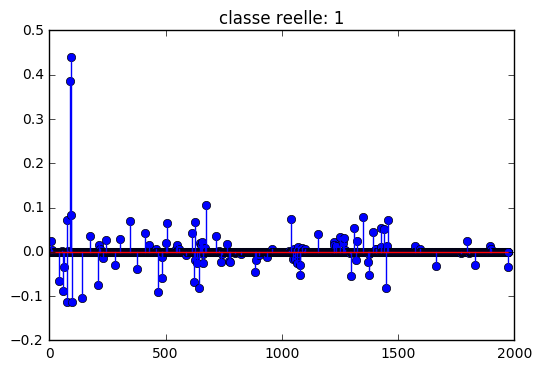

In [127]:
plt.figure()
plt.stem(x)
plt.title('classe reelle: ' + str(ytest[testval]))

Avantage : meilleure interprétabilité des résultats : on sait où il y a des erreurs et pourquoi il y a des erreurs.

### Reconstruction de l'image

### Performance sans rejection

On va regarder la précision de notre algorithme pour différents lambda.

La métrique sera le _pourcentage de bonne classification_.

In [155]:
# Rappel : 
# * y : Elément à tester (est une colonne de Xtest)
# * Xtrain : Matrice A des exemples d'entrainement
# * x : coefficients issus de la minimisation LASSO
# * ytrain : classe des exemples d'entrainement

preds = np.zeros((len(alpha_vec),Xtest.shape[1]))

for i, alpha in enumerate(alpha_vec):
    t = time.time()
    print "Coefficient de régularisation: ", alpha
    print "Boucle #",i+1,"/",len(alpha_vec)
    clf = Lasso(alpha=alpha) # on crée un modèle avec l'alpha courant
    for j in range(Xtest.shape[1]):
        # Pour chaque exemple à tester on génère les coefficients et on prend la meilleure prédiction
        y = Xtest[:,testval]
        clf.fit(Xtrain,y)
        x = clf.coef_
        
        # On fait la prédiction
        preds[i,j] = np.argmin(residu(y,Xtrain,x,ytrain))    
        
        # Affichage d'un message pour suivre l'avancement de l'algorithme
        
        if (j%50 == 0):
            print j, "exemples traités en",time.time() - t ,"s"
        
    print "Temps écoulé pour la boucle : ", time.time() - t

Coefficient de régularisation:  0.833333333333
Boucle # 1 / 10
0 exemples traités en 0.273775100708 s
50 exemples traités en 15.2376441956 s
100 exemples traités en 32.5231420994 s
150 exemples traités en 45.9040651321 s
200 exemples traités en 59.2740650177 s
250 exemples traités en 72.5607950687 s
300 exemples traités en 86.7037630081 s
350 exemples traités en 99.9445650578 s
400 exemples traités en 112.464782 s
450 exemples traités en 124.55638504 s
Temps écoulé pour la boucle :  125.723991156
Coefficient de régularisation:  1.07629138751
Boucle # 2 / 10
0 exemples traités en 0.233379125595 s
50 exemples traités en 12.681718111 s
100 exemples traités en 24.5213010311 s
150 exemples traités en 37.3608541489 s
200 exemples traités en 50.8683841228 s
250 exemples traités en 63.3426260948 s
300 exemples traités en 74.4812002182 s
350 exemples traités en 87.0840051174 s
400 exemples traités en 99.787348032 s
450 exemples traités en 111.543987036 s
Temps écoulé pour la boucle :  112.63975

On remarque que l'entrainement est spécialement long puisqu'on doit réentrainer un classifieur pour chaque exemple !

Mais c'est parallélisable

On calcule maintenant la précision pour chaque lambda

In [156]:
# Définition des classes réelles
real_classes = np.reshape(ytest*len(alpha_vec),(len(alpha_vec),len(ytest)))

# Evaluation de la précision

precision = 100*np.sum(preds == real_classes,axis=1)/len(ytest)

In [164]:
preds[5,7]

1.0

**Affichage des résultats**

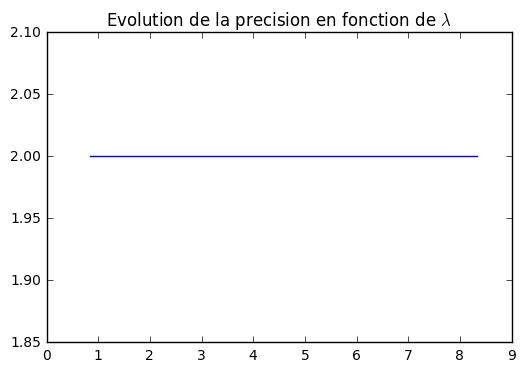

In [159]:
plt.figure()
plt.clf()
plt.plot(alpha_vec,precision)
plt.title('Evolution de la precision en fonction de $\lambda$')